#Neural Networks alternative project - LSTM

In [1]:
%pylab inline

import theano
import theano.tensor as TT

debug = True # global var to control debugging
theano.config.compute_test_value = 'warn' 

Populating the interactive namespace from numpy and matplotlib
Couldn't import dot_parser, loading of dot files will not be possible.


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [2]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [3]:
def default(var, val):
    if var is None:
        return val
    else:
        return var

In [4]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
        self._parameters = []
    
    @property
    def parameters(self):
        return self._parameters
    
    def add_param(self, name, shape, initializer, dtype='float32'):
        param = theano.shared(numpy.zeros(
            shape, dtype=dtype), name=name)
        param.tag.initializer = initializer
        self._parameters.append(param)
        setattr(self, name, param)
        
    def initialize(self):
        for p in self.parameters:
            p.set_value(p.tag.initializer.generate(self.rng, p.get_value().shape))


class RecurrentLayer(Layer):
    def __init__(self, **kwargs):
        super(RecurrentLayer, self).__init__(**kwargs)
        self.initial_states = []
    
    def apply(self, X, **kwargs):
        batch_size = X.shape[1]
        outputs_info = []
        for h in self.initial_states:
            h0 = TT.repeat(h, batch_size, axis=0)
            outputs_info.append(dict(initial=h0))
        
        #
        # Scan in theano takes a function which performs a single step of the
        # recurrent computation. Subclasses just need to provide the
        # self.transition function.
        #
        scan_result, scan_updates = theano.scan(
            self.transition,
            sequences=X,
            outputs_info=outputs_info,
            **kwargs
            )
        # Note: this in general will not be the case and we will need to
        # make sure that the updates are given to theano.function
        assert not scan_updates
        return scan_result


class MergeInputHiddens(Layer):
    """
    Merge two sequences - inputs and hidden states and produce an output.
    
    """
    def __init__(self, in_dim, hidden_dim, out_dim, weight_init=None, bias_init=None, **kwargs):
        super(MergeInputHiddens, self).__init__(**kwargs)
        weight_init = default(weight_init, IsotropicGaussian(1.0/sqrt(in_dim+hidden_dim)))
        bias_init = default(weight_init, Constant(0.))
        
        # Input to output
        self.add_param('Wxo', (in_dim, out_dim), weight_init)
        
        # Hidden to output
        self.add_param('Who', (hidden_dim, out_dim), weight_init)
        
        # Output bias
        self.add_param('Bo', (out_dim,), bias_init)
        
    def apply(self, X, H):
        # Get the shape
        nsteps, bs, nin = X.shape
        nhid = H.shape[2]
        
        # Note - we flatten the steps and batch size
        # as the computation of outputs can be performed in 
        # parallel for all time steps.
        
        O = (X.reshape((nsteps*bs, nin)).dot(self.Wxo) + 
             H.reshape((nsteps*bs, nhid)).dot(self.Who) +
             self.Bo)
        return O.reshape((nsteps, bs, O.shape[1]))
    
class Chain(Layer):
    def __init__(self, **kwargs):
        super(Chain, self).__init__(**kwargs)
        self.children = []
        
    @property
    def parameters(self):
        ret = list(self._parameters)
        for c in self.children:
            ret.extend(c.parameters)
        return ret

In [5]:
class LSTM_RNN(RecurrentLayer):
    """
    Implementation follows Alex Graves, Abdel-rahman Mohamed and Geoffrey Hinton
    "SPEECH RECOGNITION WITH DEEP RECURRENT NEURAL NETWORKS"
    http://www.cs.toronto.edu/~fritz/absps/RNN13.pdf
    """
    def __init__(self, in_dim, hidden_dim,
                 hidden_activation=TT.tanh,
                 rec_weight_init=None,
                 weight_init=None, bias_init=None, 
                 forget_bias_init=None, 
                 **kwargs):
        super(LSTM_RNN, self).__init__(**kwargs)
        
        rec_weight_init = default(rec_weight_init, IsotropicGaussian(std=0.01))
        weight_init = default(weight_init, IsotropicGaussian(std=0.01))
        bias_init = default(weight_init, Constant(0.))
        forget_bias_init = default(weight_init, Constant(1.))
        self.hidden_activation = hidden_activation
        
        #
        # Gates
        #
        
        for gate in 'ifo':
            self.add_param('Wx' + gate, (in_dim, hidden_dim), weight_init)
            self.add_param('Wh' + gate, (hidden_dim, hidden_dim), weight_init)
            # Note: a cell is only connected to its own gates
            # Wc... are diagonal - so we allocate only a vector
            # for them
            self.add_param('Wc' + gate, (hidden_dim,), weight_init)
            self.add_param('B' + gate, (hidden_dim,), bias_init)
        
        #
        # Note - forget gate bias has a different initializer, because
        # we often want to initialize it to 1
        #
        self.Bf.tag.initializer = forget_bias_init
        
        # Cell
        self.add_param('Wxc', (in_dim, hidden_dim), weight_init)
        self.add_param('Whc', (hidden_dim, hidden_dim), weight_init)
        self.add_param('Bc', (hidden_dim,), bias_init)
        
        # Initial states
        self.add_param('h0', (1, hidden_dim), bias_init)
        self.initial_states.append(self.h0)
        
        self.add_param('c0', (1, hidden_dim), bias_init)
        self.initial_states.append(self.c0)
        
        
    def transition(self, x, h, c):
        """
        One step of LSTM transition.
        
        x is the previous input
        h is the previous hidden state
        c is the previous memory cell content
        """
        
        #
        # Please note:
        # The implementation below is not speed-optimal
        # usually, it pays off to group similar matrix multiplications
        # by grouping gates.
        #
        # Also, input-related computations should be moved out of scan since
        # they can be done for all steps in parallel.
        #
        
        s = lambda x: 1.2*TT.nnet.sigmoid(x) - 0.1

        # Note: for cells we do element wise multiplication which 
        # is equvalent to a matrix multiplication with a diagonal matrix!
        i = s(x.dot(self.Wxi) + h.dot(self.Whi) + c*self.Wci + self.Bi)
        f = s(x.dot(self.Wxf) + h.dot(self.Whf) + c*self.Wcf + self.Bf)
        
        c_new = f*c + i*self.hidden_activation(x.dot(self.Wxc) + h.dot(self.Whc) + self.Bc)
        o = s(x.dot(self.Wxo) + h.dot(self.Who) + c_new*self.Wco + self.Bo)
        h_new = o * self.hidden_activation(c_new)
        
        return h_new, c_new

In [6]:
class Trainer(object):
    """
    This class computes the updates to parameters using the RMSProp learning rule and adding weight decay.
    
    """
    def __init__(self, net_loss, parameters, inputs):
        self.RMSProp_dec_rate = theano.shared(np.array(0.9, dtype='float32'))
        self.RMSProp_epsilon = theano.shared(np.array(1e-5, dtype='float32'))
        self.lrate = theano.shared(np.array(1e-2, dtype='float32'))
        self.max_grad_norm = theano.shared(np.array(1., dtype='float32'))
        self.wdec = theano.shared(np.array(0., dtype='float32'))

        theano.config.compute_test_value='off' # Turn off for gradient computation
        
        wdec_loss = 0
        for p in parameters:
            if p.name[0]=='W':
                wdec_loss = wdec_loss + (p**2).sum()*self.wdec
        
        grads = theano.grad(net_loss + wdec_loss, parameters)
        updates = []

        grad_norm = 0.
        
        #rs = TT.shared_randomstreams.RandomStreams(seed=2568)
        
        for g in grads:
            grad_norm = grad_norm + (g**2).sum()
        

        for g,p in zip(grads, parameters):
            step = g #+ rs.normal(size=g.shape, avg=0.0, std=0.01)
            step = g / TT.maximum(1.0, grad_norm/self.max_grad_norm)
            if 1:
                g2 = theano.shared(p.get_value() * 0., name=p.name + '_g2')
                g2_new = (self.RMSProp_dec_rate * g2 + (1.0 - self.RMSProp_dec_rate) * g**2) 
                updates.append((g2, g2_new))
                step = step / TT.sqrt(g2_new + self.RMSProp_epsilon)

            step = self.lrate * step
            updates.append((p, p - step))

        self.train_function = theano.function(inputs, 
                                              [net_loss, net_loss + wdec_loss, grad_norm], 
                                              updates=updates)

In [7]:
class AdditionNet(Chain):
    def __init__(self, hidden_dim, num_layers=1,
                 use_lstm=True,
                 **kwargs):
        super(AdditionNet, self).__init__(**kwargs)
        self.use_lstm = use_lstm
        self.recs = []
        
        #
        # Here we introduce a multilayer LSTM network. We simply feed the hidden states of the
        # lower layers as the inputs of the higher ones. Optionally, the inputs can also be connected
        # to the upper layers (not implemented in the code).
        #
        
        for hid in xrange(num_layers):
            if hid == 0:
                in_dim = 2
            else:
                in_dim = hidden_dim
            if use_lstm:
                rec = LSTM_RNN(in_dim=in_dim, hidden_dim=hidden_dim,
                               rec_weight_init=IsotropicGaussian(std=np.sqrt(6.0/(in_dim+hidden_dim))),
                               weight_init=IsotropicGaussian(std=np.sqrt(6.0/(in_dim+hidden_dim))))
            else:
                rec = SimpleRNN(in_dim=in_dim, hidden_dim=hidden_dim)
            self.recs.append(rec)
            self.children.append(rec)
        
        self.merge = MergeInputHiddens(in_dim=2, hidden_dim=hidden_dim, out_dim=1)
        self.children.append(self.merge)
        
        self.X = TT.tensor3('X')
        self.Y = TT.matrix('Y')
        
        self.inputs = [self.X, self.Y]
    
    def apply(self, X):
        H = X
        for rec in self.recs:
            H = rec.apply(H)
            if self.use_lstm: # we don't use cell contents
                H = H[0]
        O = self.merge.apply(X[-1:], H[-1:])
        return O

    def get_loss(self):
        net_output = self.apply(self.X)
        return ((net_output - self.Y)**2).mean()
    
    def get_prediction(self):
        return self.apply(self.X)

In [8]:
def gen_addition_example(T, batchsize):
    rng = numpy.random
    
    l = rng.randint(T, int(T * 1.1+0.9))
    p0 = rng.randint(0, int(l*.1), size=(batchsize,))
    p1 = rng.randint(0, int(l*.4), size=(batchsize,)) + int(l*.1)
    
    X = rng.uniform(size=(l, batchsize, 2)).astype('float32')
    X[:,:,0] = 0.
    X[p0, numpy.arange(batchsize), numpy.zeros((batchsize,), dtype='int32')] = 1.
    X[p1, numpy.arange(batchsize), numpy.zeros((batchsize,), dtype='int32')] = 1.

    Y = (X[p0, numpy.arange(batchsize), 
           numpy.ones((batchsize,), dtype='int32')] + X[p1, numpy.arange(batchsize),
           numpy.ones((batchsize,), dtype='int32')])#/2.
    return X, Y.reshape((-1,1)).astype('float32')

Xa,Ya = gen_addition_example(10, 3)
print 'X:', Xa[:,0,:], '\nY:', Ya[0,:]

X: [[ 1.          0.78095645]
 [ 1.          0.51783735]
 [ 0.          0.97049165]
 [ 0.          0.04075842]
 [ 0.          0.95107001]
 [ 0.          0.5534125 ]
 [ 0.          0.2203576 ]
 [ 0.          0.69852966]
 [ 0.          0.76626372]
 [ 0.          0.70823675]] 
Y: [ 1.29879379]


In [9]:
def generate_addition_example(T, batchsize, p=0.3):
    rng = numpy.random
    
    x = rng.uniform(size=(batchsize, T)).astype('float32')
    #y = rng.binomial(1, p, size=(batchsize, T))

    i1 = rng.randint(0,T/2, batchsize)
    i2 = rng.randint(T/2, T, batchsize)

    y = np.zeros((batchsize, T))
    y[np.arange(batchsize), i1] = 1
    y[np.arange(batchsize), i2] = 1

    X = np.array([y,x], dtype='float32')
    Y = (x*y).sum(axis=1, keepdims=True, dtype='float32')
    
    return X.T, Y


Xa,Ya = generate_addition_example(10, 3)
print 'X:', Xa[:,0,:], '\nY:', Ya[0,:]

X: [[ 0.          0.67482436]
 [ 0.          0.32540825]
 [ 0.          0.67874742]
 [ 1.          0.91665357]
 [ 0.          0.87246037]
 [ 0.          0.9350369 ]
 [ 0.          0.75230014]
 [ 0.          0.49452159]
 [ 0.          0.50290304]
 [ 1.          0.49849886]] 
Y: [ 1.41515243]


In [10]:
theano.config.compute_test_value='off'
theano.config.print_test_value=True
debug = False

addition_net = AdditionNet(hidden_dim=128, use_lstm=True)
addition_net.initialize()

addition_net_prediction = addition_net.get_prediction()
addition_prediction_function = theano.function([addition_net.X], addition_net_prediction)

addition_net_loss = addition_net.get_loss()
addition_test_function = theano.function(addition_net.inputs, addition_net_loss)

Xa, Ya = gen_addition_example(10,20)
print addition_test_function(Xa, Ya)

1.65228176117


/pio/os/anaconda/lib/python2.7/site-packages/theano/gof/cmodule.py:293: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  rval = __import__(module_name, {}, {}, [module_name])


In [11]:
addition_trainer = Trainer(addition_net_loss, addition_net.parameters, addition_net.inputs)

0 [array(1.6149386167526245, dtype=float32), array(1.9259439706802368, dtype=float32), array(405.6430358886719, dtype=float32)]
500 [array(0.15606465935707092, dtype=float32), array(0.3920886814594269, dtype=float32), array(0.3616131842136383, dtype=float32)]
1000 [array(0.13039834797382355, dtype=float32), array(0.25669631361961365, dtype=float32), array(0.005762946326285601, dtype=float32)]
1500 [array(0.1810222864151001, dtype=float32), array(0.24864710867404938, dtype=float32), array(0.45726674795150757, dtype=float32)]
2000 [array(0.18461807072162628, dtype=float32), array(0.22082793712615967, dtype=float32), array(0.06971042603254318, dtype=float32)]
2500 [array(0.17097461223602295, dtype=float32), array(0.19044753909111023, dtype=float32), array(0.0025131870061159134, dtype=float32)]
3000 [array(0.13598152995109558, dtype=float32), array(0.146625816822052, dtype=float32), array(0.004242995288223028, dtype=float32)]
3500 [array(0.1890420913696289, dtype=float32), array(0.19488862

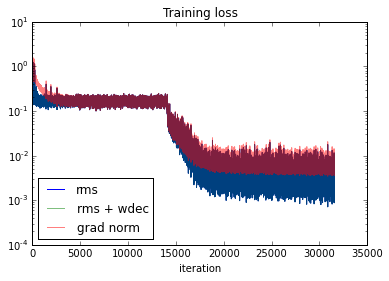

In [12]:
addition_net.initialize()

# you can tweek the learning rate. 1e-2 worked best for me
if addition_net.use_lstm:
    addition_trainer.lrate.set_value(1e-2)
else:
    addition_trainer.lrate.set_value(1e-3)
addition_trainer.max_grad_norm.set_value(4.)
# weight decay seems to be important for generalization
addition_trainer.wdec.set_value(1e-4)

losses = []


try:
    for i in xrange(300000):
        this_len = 100
        Xa, Ya = generate_addition_example(this_len, 100)
        ret = addition_trainer.train_function(Xa, Ya)
        losses.append((i,) + tuple(ret))
        if ret[0] < 0.0002:
            break
        if i%500 == 0:
            print i, ret

except KeyboardInterrupt:
    pass


losses_a = np.array(losses)

semilogy(losses_a[:,0], losses_a[:,1], label='rms')
semilogy(losses_a[:,0], losses_a[:,1], alpha=0.5, label='rms + wdec')
plot(losses_a[:,0], losses_a[:,2], alpha=0.5, label='grad norm')

legend(loc='lower left')
title('Training loss')
xlabel('iteration')

In [18]:
Xa, Ya = generate_addition_example(50,100)
addition_test_function(Xa, Ya)

array(0.003566255560144782, dtype=float32)

In [19]:
err_list = []
for t in xrange(10,3011,50):
    Xa, Ya = generate_addition_example(t,200)
    err_list.append(addition_test_function(Xa, Ya))
    
print "done"

done


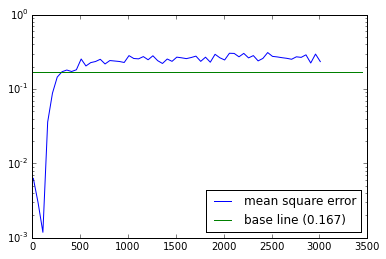

In [20]:
err_l = err_list
semilogy(xrange(10, 3011, 50), err_l, label="mean square error")
semilogy(xrange(0, 3500, 50), [0.167]*len(xrange(0, 3500, 50)), label="base line (0.167)")
legend(loc="lower right")

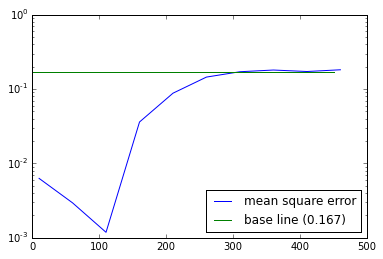

In [21]:
err_l = err_list
semilogy(xrange(10, 500, 50), err_l[:len(xrange(10, 500, 50))], label="mean square error")
semilogy(xrange(0, 500, 50), [0.167]*len(xrange(0, 500, 50)), label="base line (0.167)")
legend(loc="lower right")